In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
from sksparse.cholmod import cholesky

from scipy.sparse.linalg import onenormest, splu, LinearOperator

from pyiga import bspline
from pyiga import utils
from pyiga.bspline import BSplineFunc
from pyiga.tensor import apply_tprod
from pyiga import adaptive as adap

import functools
import itertools

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def condest(A):
    luA = splu(A)
    iA = LinearOperator(luA.shape, matvec = lambda x : luA.solve(x), rmatvec = lambda x : luA.solve(x))
    return onenormest(iA)*onenormest(A)

In [3]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)


In [4]:
def Inductor(deg,N):
    kvs=42*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    
    geos=[      
        geometry.unit_square().scale((0.5)).translate((-0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,-0.5)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,-0.5)),
        geometry.unit_square().scale(0.5).translate((1.5,-0.5)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0)),
        geometry.unit_square().scale(0.25),
        geometry.unit_square().scale(0.25).translate((0.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0)),
        
        geometry.unit_square().scale((0.5,0.025)).translate((-0.5,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((0,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((0.25,0.25)),
        geometry.unit_square().scale((0.5,0.025)).translate((0.5,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((1.,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((1.25,0.25)),
        geometry.unit_square().scale((0.5,0.025)).translate((1.5,0.25)),
        
        geometry.unit_square().scale((0.5,0.5)).translate((-0.5,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,0.275)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,0.275)),
        geometry.unit_square().scale((0.5,0.5)).translate((1.5,0.275)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((0,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((0.25,0.775)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0.775)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0.775)),
        
        geometry.unit_square().scale(0.5).translate((-0.5,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,1.025)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,1.025)),
        geometry.unit_square().scale(0.5).translate((1.5,1.025)),
         ]
    patches=list(zip(kvs,geos))
    M = topology.PatchMesh(patches)
    M.rename_domain(0,'Air')
    M.set_domain_id({'Fe':{8,9,10,11,12,22,24,26,29,30,31,32,33}, 'C1':{23}, 'C2':{25}})
    return M

In [5]:
mu0 = 4*pi*1e-7
nu = {'C1': 1/mu0, 'C2':1/mu0, 'Fe':1/(2500*mu0), 'Air': 1/mu0}
j = {'C1': lambda x,y: 66/(0.125), 'C2':lambda x,y: -66/(0.125), 'Fe':lambda x,y: 0.0, 'Air': lambda x,y: 0.0}
MaT = {'C1': lambda x,y: (0.,0.), 'C2': lambda x,y:(0.,0.), 'Fe':lambda x,y:(0.,0.), 'Air': lambda x,y:(0.,0.)}

In [13]:
def uniform(deg, maxiter=5):
    M = Inductor(deg,deg+1)
    MP = assemble.Multipatch(M, automatch=True)
    uh=[]
    numdofs = np.zeros(maxiter,dtype=float)
    P=[]
    return_P = True
    Eh=np.zeros(maxiter)
    
    time_mesh = np.zeros(maxiter)
    time_solve = np.zeros(maxiter)
    nnz = np.zeros(maxiter)
    nnzQ = np.zeros(maxiter)
    # nnzL = np.zeros(maxiter)
    # nnzLQ = np.zeros(maxiter)
    Eh = np.zeros(maxiter)
    #cond = np.zeros(maxiter)

    for i in range(maxiter):
        print('----------------------------------------------------')
        print(i)
        bcs = MP.compute_dirichlet_bcs({0:0.})
        Ah = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP.assemble_volume('(j * v) * dx', arity=1, domain_id=k, j=j[k], physical=True) for k in j],axis=0)
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        Mh = MP.assemble_volume(vform.mass_vf(2))
        LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
        
        nnz[i] = LS.A.nnz
        nnzQ[i] = 100*LS.A.nnz/np.prod(LS.A.shape)
        # if i < 6:
        #     cond[i]=condest(LS.A)
        # solver = scipy.sparse.linalg.splu(LS.A)
        # nnzL[i] = solver.L.nnz
        # nnzLQ[i] = 100*solver.L.nnz/np.prod(solver.L.shape)
        
        t=time.time()
        uh.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
        time_solve[i] = time.time()-t
        numdofs[i] = MP.numdofs
        Eh[i] = 0.0254 * 0.5 * uh[-1]@Ah@uh[-1]
        print('Number of doFs: ' + str(MP.numdofs))
        print('Energy: ' + str(Eh[i]))

        t=time.time()
        if i < maxiter-2:
            P.append(MP.h_refine(h_ref=-1, return_P=return_P))
        elif i == maxiter-2:
            P.append(MP.p_refine(p_inc=1, return_P=return_P))
        else:
            pass
        time_mesh[i]=time.time()-t

    for k in reversed(range(1,len(P))):
        P[k-1]=P[k]@P[k-1]

    L2err = np.zeros(maxiter)
    H1err = np.zeros(maxiter)
    Aherr = np.zeros(maxiter)
    Eherr = np.zeros(maxiter)
    for i in range(len(uh)-1):
        eh = P[i]@uh[i]-uh[-1]
        L2err[i] = eh @ Mh @ eh
        H1err[i] = eh @ Kh @ eh + L2err[i]
        Aherr[i] = eh @ Ah @ eh

    L2err = sqrt(L2err)
    H1err = sqrt(H1err)
    Aherr = sqrt(Aherr)
    
    return MP, numdofs, uh, nnz, nnzQ, L2err, H1err, Aherr, Eh, time_mesh, time_solve

In [28]:
def geometric(deg, maxiter=15, returnP =True):
    M = Inductor(deg,deg+1)
    MP = assemble.Multipatch(M, automatch=True)
    uh=[]
    numdofs = np.zeros(maxiter,dtype=float)
    P=[]
    return_P = True
    
    time_mesh = np.zeros(maxiter)
    time_solve = np.zeros(maxiter)
    nnz = np.zeros(maxiter)
    nnzQ = np.zeros(maxiter)
    #nnzL = np.zeros(maxiter)
    #nnzLQ = np.zeros(maxiter)
    Eh = np.zeros(maxiter)
    cond = np.zeros(maxiter)

    for i in range(maxiter):
        print('----------------------------------------------------')
        print(i)
        MP.mesh.draw(color={'C1':'yellow', 'C2':'yellow','Fe':'darkgrey','Air':'white'},knots=True)
        bcs = MP.compute_dirichlet_bcs({0:0.})
        Ah = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP.assemble_volume('(j * v) * dx', arity=1, domain_id=k, j=j[k], physical=True) for k in j],axis=0)
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        Mh = MP.assemble_volume(vform.mass_vf(2))
        LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
        
        nnz[i] = LS.A.nnz
        nnzQ[i] = 100*LS.A.nnz/np.prod(LS.A.shape)
        # if i < 5:
        #     cond[i]=condest(LS.A)
        # solver = scipy.sparse.linalg.splu(LS.A)
        # nnzL[i] = solver.L.nnz
        # nnzLQ[i] = 100*solver.L.nnz/np.prod(solver.L.shape)
        
        t=time.time()
        uh.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
        time_solve[i]=time.time()-t
        
        numdofs[i] = MP.numdofs
        Eh[i] = 0.0254 * 0.5 * uh[-1]@Ah@uh[-1]
        #Eh[i] = MP.integrate('0.5 * nu * inner(grad(uh),grad(uh)) * v * dx', u_ =uh[-1], nu=nu)*0.0254
        print('Number of doFs: ' + str(MP.numdofs))
        print('Energy: ' + str(Eh[i]))

        t = time.time()
        if i < maxiter-2:
            if i%5==0:
                P.append(MP.h_refine(h_ref=-1, return_P=return_P))
            else:
                P.append(MP.h_refine(h_ref='q', return_P=return_P))
        elif i == maxiter-2:
            P.append(MP.p_refine(p_inc=1, return_P=return_P))
        else:
            pass
        time_mesh[i] = time.time()-t

    for k in reversed(range(1,len(P))):
        P[k-1]=P[k]@P[k-1]

    L2err = np.zeros(maxiter)
    H1err = np.zeros(maxiter)
    Aherr = np.zeros(maxiter)
    Eherr = np.zeros(maxiter)
    
    if returnP:
        for i in range(len(uh)-1):
            eh = P[i]@uh[i]-uh[-1]
            L2err[i] = eh @ Mh @ eh
            H1err[i] = eh @ Kh @ eh + L2err[i]
            Aherr[i] = eh @ Ah @ eh

        L2err = sqrt(L2err)
        H1err = sqrt(H1err)
        Aherr = sqrt(Aherr)
    
    return MP, numdofs, uh, nnz, nnzQ, L2err, H1err, Aherr, Eh, time_mesh, time_solve

In [30]:
M = Inductor(2,3)
MP = assemble.Multipatch(M, automatch=True)

Basis setup took 0.013529777526855469 seconds


In [15]:
for deg, maxiter in zip((2,3,4),(8,7,6)):
    MP, numdofs, uh, nnz, nnzQ, L2err, H1err, Aherr, Eh, time_mesh, time_solve = uniform(deg,maxiter)
    np.savetxt('Ip'+str(deg)+'n'+str(deg+1)+'uni.txt', np.c_[[numdofs, nnz, nnzQ, H1err,L2err,Aherr,Eh,time_mesh,time_solve]])

Basis setup took 0.012796163558959961 seconds
----------------------------------------------------
0
Number of doFs: 725
Energy: 0.0008654770655053184
Refinement took 0.0014262199401855469 seconds for 42 patches.
Basis setup took 0.014603614807128906 seconds
Prolongation took 0.07356715202331543 seconds
----------------------------------------------------
1
Number of doFs: 2150
Energy: 0.0008763649541303452
Refinement took 0.0014693737030029297 seconds for 42 patches.
Basis setup took 0.019646406173706055 seconds
Prolongation took 0.08176279067993164 seconds
----------------------------------------------------
2
Number of doFs: 7268
Energy: 0.0008815644860982698
Refinement took 0.0016400814056396484 seconds for 42 patches.
Basis setup took 0.03255200386047363 seconds
Prolongation took 0.08405208587646484 seconds
----------------------------------------------------
3
Number of doFs: 26576
Energy: 0.0008836790055448084
Refinement took 0.0016796588897705078 seconds for 42 patches.
Basis s

Basis setup took 0.012764692306518555 seconds
----------------------------------------------------
0
Number of doFs: 725
Energy: 0.0008654770655053184
Refinement took 0.001542806625366211 seconds for 42 patches.
Basis setup took 0.01479649543762207 seconds
Prolongation took 0.0735940933227539 seconds
----------------------------------------------------
1
Number of doFs: 2150
Energy: 0.0008763649541303452
Refinement took 0.0015094280242919922 seconds for 42 patches.
Basis setup took 0.016039609909057617 seconds
Prolongation took 0.07544493675231934 seconds
----------------------------------------------------
2
Number of doFs: 3520
Energy: 0.0008815003200585244
Refinement took 0.0016524791717529297 seconds for 42 patches.
Basis setup took 0.01764988899230957 seconds
Prolongation took 0.07396888732910156 seconds
----------------------------------------------------
3
Number of doFs: 5226
Energy: 0.0008836367976987635
Refinement took 0.001641988754272461 seconds for 42 patches.
Basis setup 

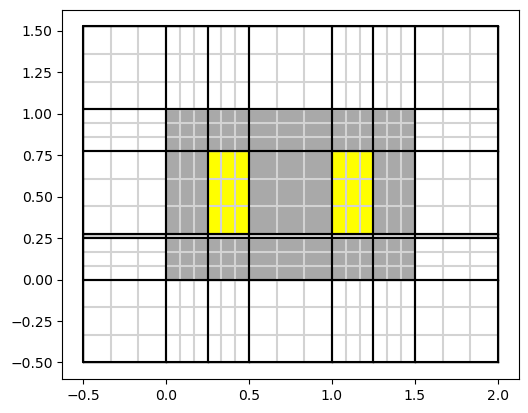

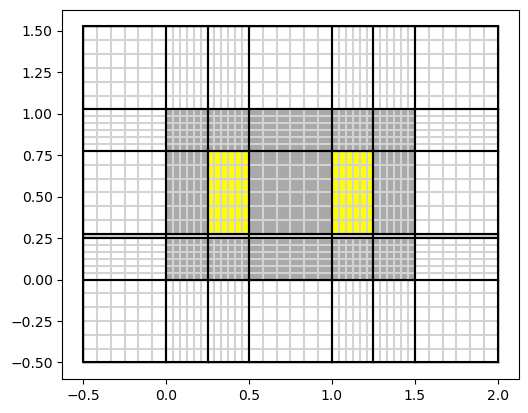

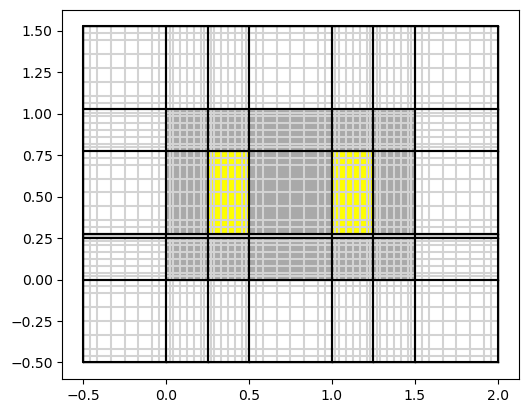

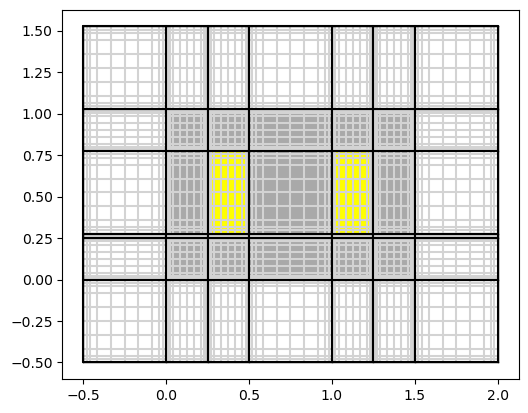

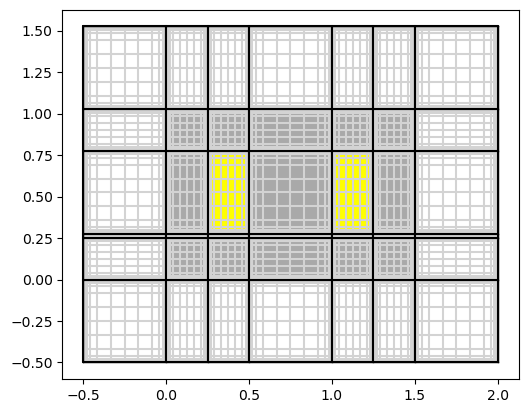

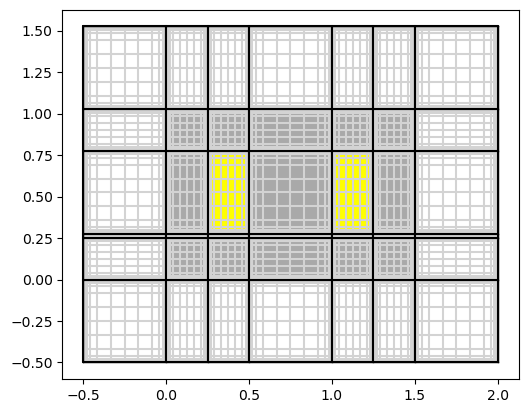

In [29]:
for deg, maxiter in zip((2,),(6,)):
    MP_geo, numdofs_geo, uh, nnz_geo, nnzQ_geo, L2err_geo, H1err_geo, Aherr_geo, Eh_geo, time_mesh_geo, time_solve_geo = geometric(deg,maxiter)
    #np.savetxt('Ip'+str(deg)+'n'+str(deg+1)+'geo.txt', np.c_[[numdofs_geo, nnz_geo, nnzQ_geo , H1err_geo, L2err_geo, Aherr_geo, Eh_geo, time_mesh_geo, time_solve_geo]])

Basis setup took 0.012824773788452148 seconds
------------------------------------------------------
0
Number of DoFs: 725
Energy: 0.0008654770655053184
Residual contributions took 0.2712581157684326 seconds.
Jump contributions took 0.4387052059173584 seconds.
Refinement took 0.05110621452331543 seconds for 9 patches.
Basis setup took 0.024189472198486328 seconds
Prolongation took 0.06326723098754883 seconds


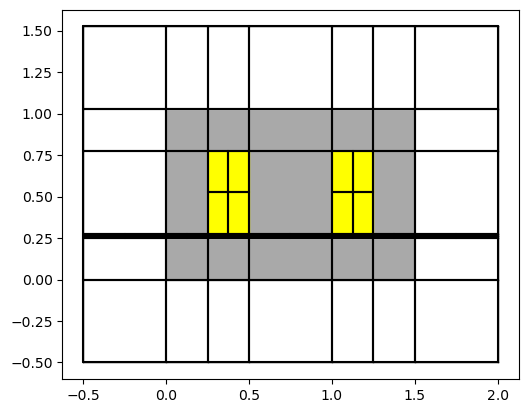

------------------------------------------------------
1
Number of DoFs: 1125
Energy: 0.0008684078435585317
Residual contributions took 0.43335962295532227 seconds.
Jump contributions took 0.9203405380249023 seconds.
Refinement took 0.15505623817443848 seconds for 19 patches.
Basis setup took 0.03811049461364746 seconds
Prolongation took 0.13147306442260742 seconds


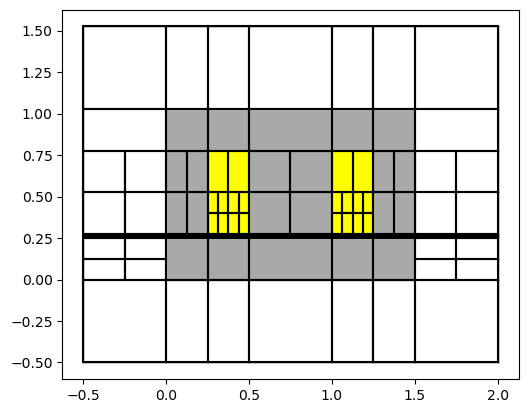

------------------------------------------------------
2
Number of DoFs: 1985
Energy: 0.0008767150110374723
Residual contributions took 0.8089041709899902 seconds.
Jump contributions took 1.8639018535614014 seconds.
Refinement took 0.35845208168029785 seconds for 28 patches.
Basis setup took 0.06697797775268555 seconds
Prolongation took 0.19357085227966309 seconds


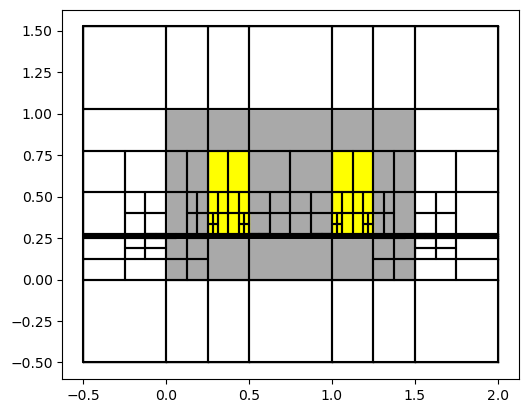

------------------------------------------------------
3
Number of DoFs: 3221
Energy: 0.0008804457397790856
Residual contributions took 1.3098511695861816 seconds.
Jump contributions took 3.2717020511627197 seconds.
Refinement took 0.5403804779052734 seconds for 31 patches.
Basis setup took 0.10828661918640137 seconds
Prolongation took 0.219512939453125 seconds


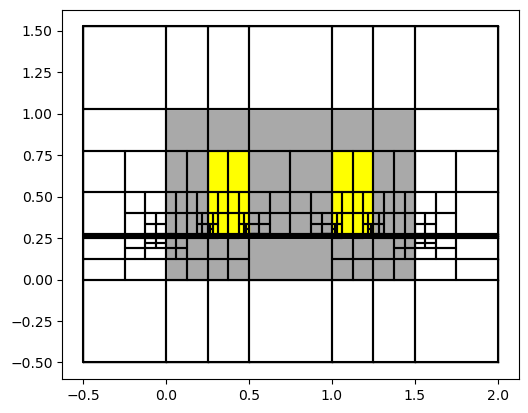

------------------------------------------------------
4
Number of DoFs: 4633
Energy: 0.0008829311594725111
Residual contributions took 1.881380319595337 seconds.
Jump contributions took 4.867363214492798 seconds.
Refinement took 0.8563520908355713 seconds for 37 patches.
Basis setup took 0.12912917137145996 seconds
Prolongation took 0.26291394233703613 seconds


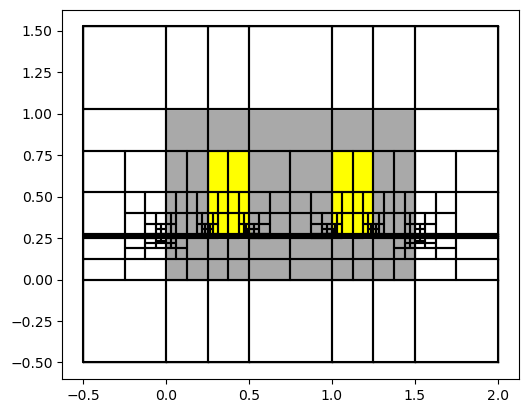

------------------------------------------------------
5
Number of DoFs: 6261
Energy: 0.0008840599712469546
Residual contributions took 2.5502853393554688 seconds.
Jump contributions took 6.6153950691223145 seconds.
Refinement took 1.4252312183380127 seconds for 47 patches.
Basis setup took 0.17556381225585938 seconds
Prolongation took 0.33188939094543457 seconds


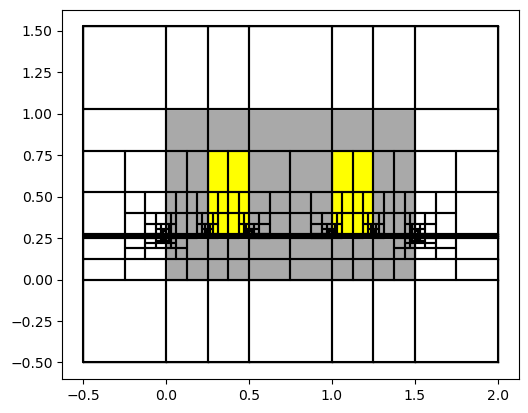

------------------------------------------------------
6
Number of DoFs: 8377
Energy: 0.0008845205904996055
Residual contributions took 3.445514440536499 seconds.
Jump contributions took 8.948054075241089 seconds.
Refinement took 2.5979013442993164 seconds for 64 patches.
Basis setup took 0.25690770149230957 seconds
Prolongation took 0.4586014747619629 seconds


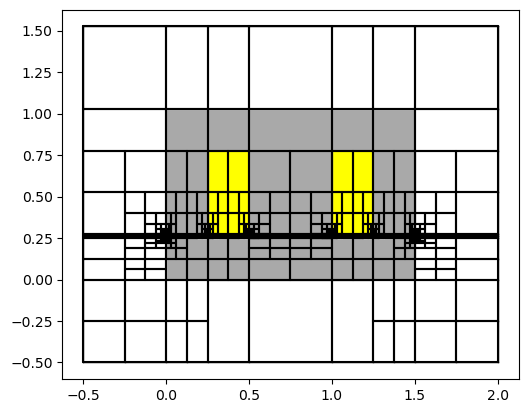

------------------------------------------------------
7
Number of DoFs: 11217
Energy: 0.0008847381322172564
Residual contributions took 4.630887746810913 seconds.
Jump contributions took 12.082975625991821 seconds.
Refinement took 4.523394823074341 seconds for 85 patches.
Basis setup took 0.410994291305542 seconds
Prolongation took 0.6266858577728271 seconds


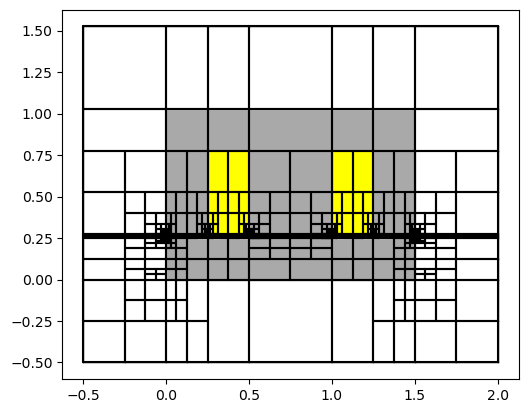

------------------------------------------------------
8
Number of DoFs: 15029
Energy: 0.0008848370442656132
Residual contributions took 6.233076572418213 seconds.
Jump contributions took 16.544549465179443 seconds.
Refinement took 7.380960702896118 seconds for 106 patches.
Basis setup took 0.5007376670837402 seconds
Prolongation took 0.7925889492034912 seconds


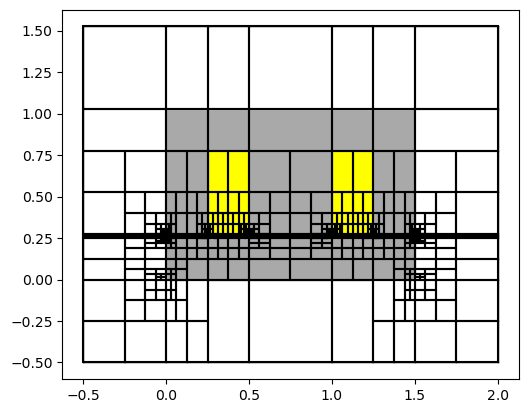

------------------------------------------------------
9
Number of DoFs: 19741
Energy: 0.0008849009264656526
Residual contributions took 8.226480722427368 seconds.
Jump contributions took 21.463706493377686 seconds.
Refinement took 9.95292353630066 seconds for 113 patches.
Basis setup took 0.6721365451812744 seconds
Prolongation took 0.8541362285614014 seconds


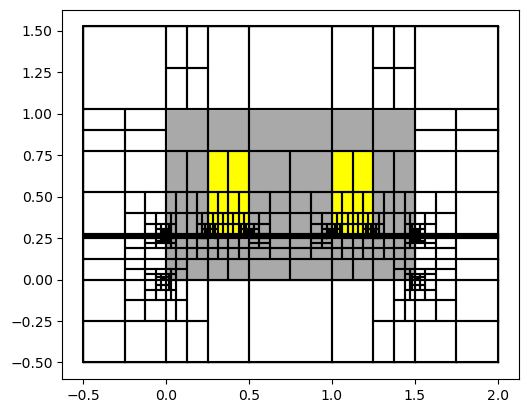

------------------------------------------------------
10
Number of DoFs: 24797
Energy: 0.0008849191456741418
Residual contributions took 10.354659795761108 seconds.
Jump contributions took 27.234840869903564 seconds.
Refinement took 17.14102292060852 seconds for 154 patches.
Basis setup took 0.9657135009765625 seconds
Prolongation took 1.2005047798156738 seconds


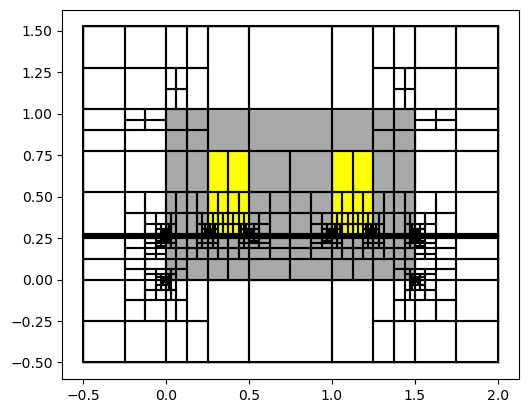

------------------------------------------------------
11
Number of DoFs: 31689
Energy: 0.0008849340348785914
Residual contributions took 13.294860124588013 seconds.
Jump contributions took 35.04487991333008 seconds.
Refinement took 24.95065975189209 seconds for 177 patches.
Basis setup took 1.5484728813171387 seconds
Prolongation took 1.449345588684082 seconds


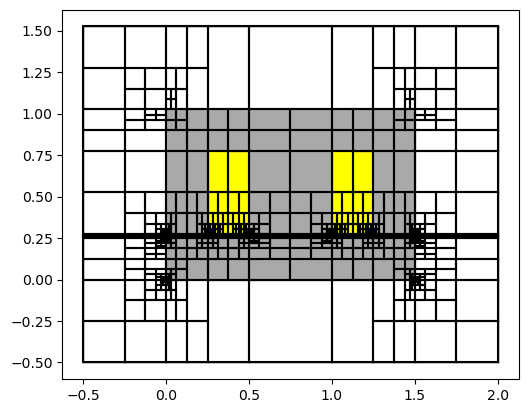

------------------------------------------------------
12
Number of DoFs: 39597
Energy: 0.0008849701134920635
Residual contributions took 16.608986377716064 seconds.
Jump contributions took 44.15195345878601 seconds.
Refinement took 43.141815185546875 seconds for 243 patches.
Basis setup took 1.894129991531372 seconds
Prolongation took 2.0461976528167725 seconds


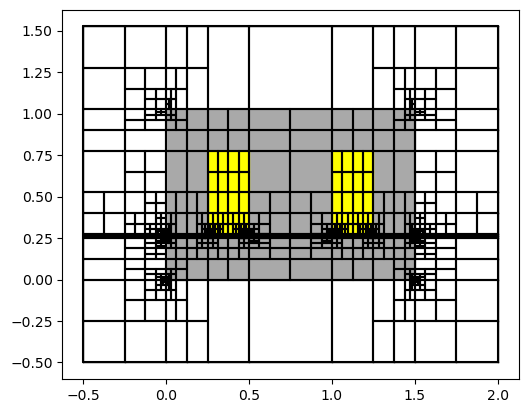

------------------------------------------------------
13
Number of DoFs: 50449
Energy: 0.0008849718839495152
Basis setup took 3.6482629776000977 seconds
Prolongation took 7.036385536193848 seconds
------------------------------------------------------
14
Number of DoFs: 159286
Energy: 0.0008849900577920505
Basis setup took 0.014674663543701172 seconds
------------------------------------------------------
0
Number of DoFs: 1591
Energy: 0.0008771873428446199
Residual contributions took 0.27338075637817383 seconds.
Jump contributions took 0.437558650970459 seconds.
Refinement took 0.05070137977600098 seconds for 9 patches.
Basis setup took 0.026340961456298828 seconds
Prolongation took 0.06390976905822754 seconds


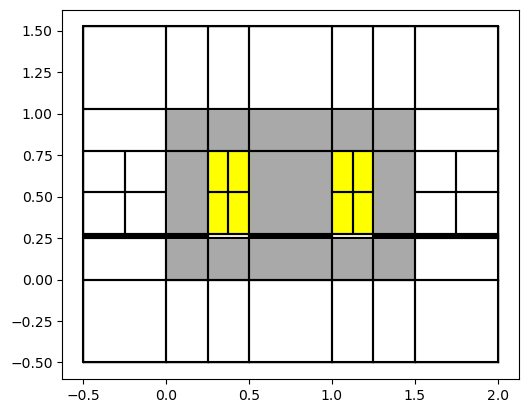

------------------------------------------------------
1
Number of DoFs: 2503
Energy: 0.0008787653486900858
Residual contributions took 0.4475264549255371 seconds.
Jump contributions took 0.9281692504882812 seconds.
Refinement took 0.09848165512084961 seconds for 13 patches.
Basis setup took 0.0364689826965332 seconds
Prolongation took 0.09232711791992188 seconds


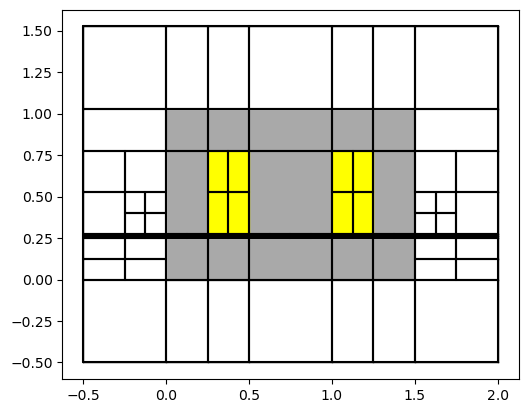

------------------------------------------------------
2
Number of DoFs: 3847
Energy: 0.0008793935595376011
Residual contributions took 0.6663100719451904 seconds.
Jump contributions took 1.5786101818084717 seconds.
Refinement took 0.23646926879882812 seconds for 22 patches.
Basis setup took 0.05951738357543945 seconds
Prolongation took 0.1550302505493164 seconds


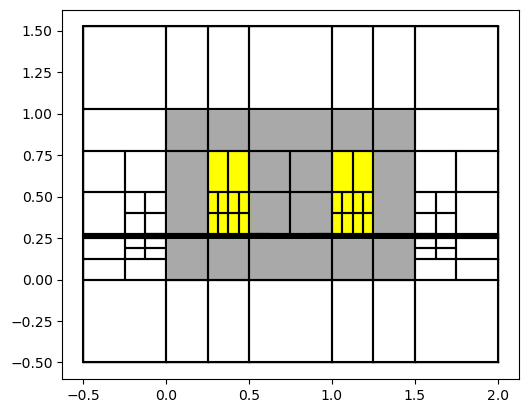

------------------------------------------------------
3
Number of DoFs: 6085
Energy: 0.0008810478947388002
Residual contributions took 1.1029224395751953 seconds.
Jump contributions took 2.7185792922973633 seconds.
Refinement took 0.37393617630004883 seconds for 25 patches.
Basis setup took 0.08954858779907227 seconds
Prolongation took 0.17702841758728027 seconds


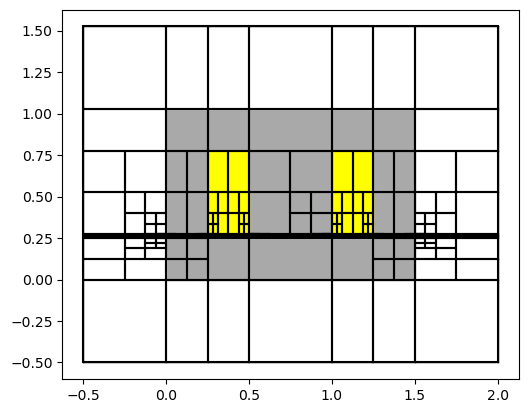

------------------------------------------------------
4
Number of DoFs: 8653
Energy: 0.0008830313636711724
Residual contributions took 1.4515266418457031 seconds.
Jump contributions took 3.9349563121795654 seconds.
Refinement took 0.6380000114440918 seconds for 32 patches.
Basis setup took 0.13532018661499023 seconds
Prolongation took 0.23621630668640137 seconds


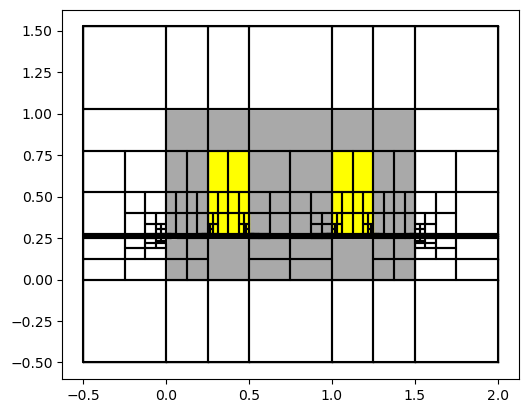

------------------------------------------------------
5
Number of DoFs: 11923
Energy: 0.0008840795243590435
Residual contributions took 2.0263588428497314 seconds.
Jump contributions took 5.578007698059082 seconds.
Refinement took 1.036512851715088 seconds for 39 patches.
Basis setup took 0.17716050148010254 seconds
Prolongation took 0.28130197525024414 seconds


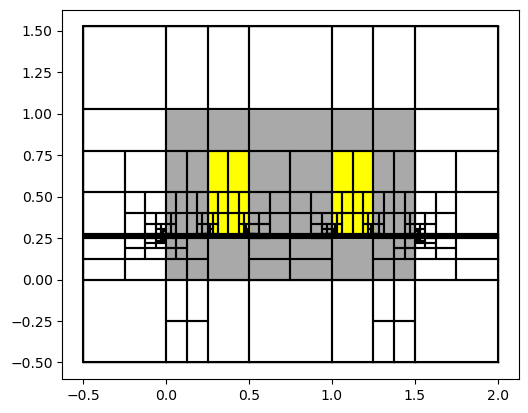

------------------------------------------------------
6
Number of DoFs: 15925
Energy: 0.0008846040352565993
Residual contributions took 2.6897754669189453 seconds.
Jump contributions took 7.513993978500366 seconds.
Refinement took 1.761469841003418 seconds for 51 patches.
Basis setup took 0.23607349395751953 seconds
Prolongation took 0.3742644786834717 seconds


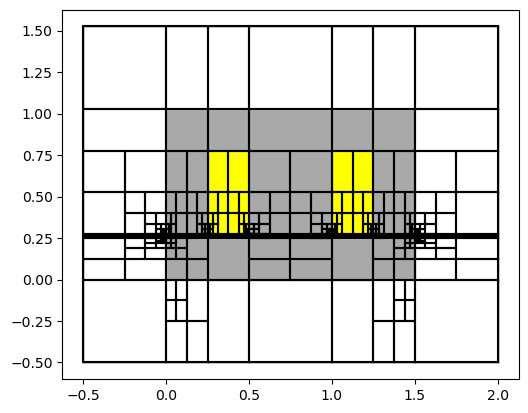

------------------------------------------------------
7
Number of DoFs: 21157
Energy: 0.0008848243104454123
Residual contributions took 3.583747625350952 seconds.
Jump contributions took 10.044686079025269 seconds.
Refinement took 2.755678415298462 seconds for 62 patches.
Basis setup took 0.40951967239379883 seconds
Prolongation took 0.4605076313018799 seconds


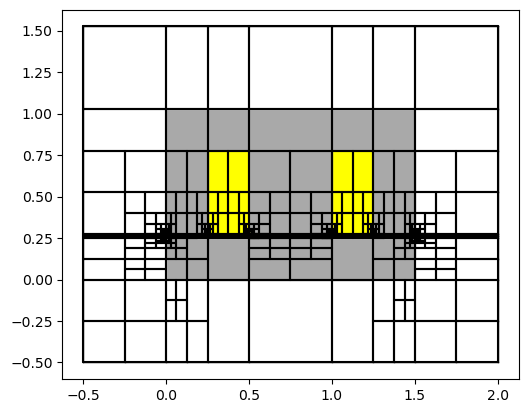

------------------------------------------------------
8
Number of DoFs: 27589
Energy: 0.0008849163272779268
Residual contributions took 4.688869953155518 seconds.
Jump contributions took 13.02831768989563 seconds.
Refinement took 3.79710054397583 seconds for 69 patches.
Basis setup took 0.49904847145080566 seconds
Prolongation took 0.515282154083252 seconds


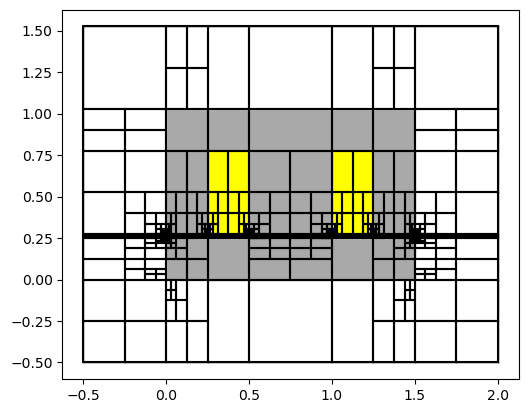

------------------------------------------------------
9
Number of DoFs: 34681
Energy: 0.000884950534893127
Residual contributions took 5.884622573852539 seconds.
Jump contributions took 16.54105854034424 seconds.
Refinement took 5.913889408111572 seconds for 86 patches.
Basis setup took 0.6390843391418457 seconds
Prolongation took 0.6507470607757568 seconds


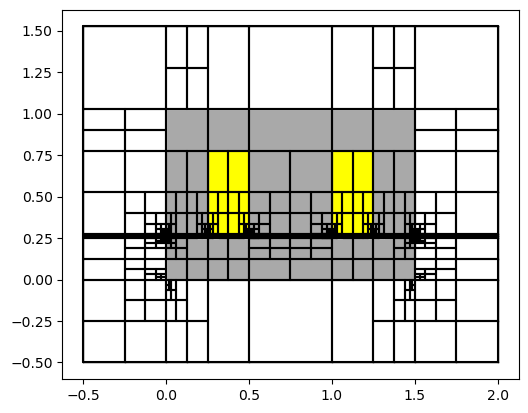

------------------------------------------------------
10
Number of DoFs: 43597
Energy: 0.0008849666600571777
Residual contributions took 7.551185607910156 seconds.
Jump contributions took 20.684568881988525 seconds.
Refinement took 9.145532131195068 seconds for 108 patches.
Basis setup took 0.9011523723602295 seconds
Prolongation took 0.8332059383392334 seconds


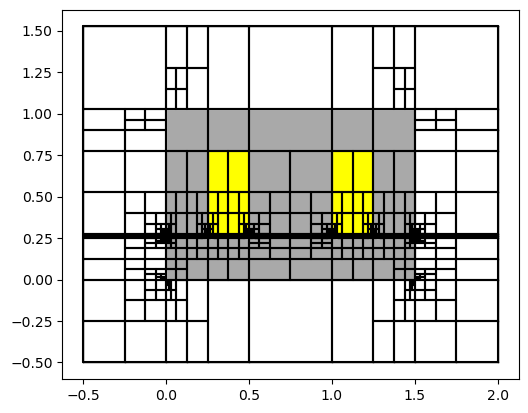

------------------------------------------------------
11
Number of DoFs: 54685
Energy: 0.0008849736618244643
Residual contributions took 9.234009027481079 seconds.
Jump contributions took 26.541715383529663 seconds.
Refinement took 12.81150484085083 seconds for 122 patches.
Basis setup took 1.4482736587524414 seconds
Prolongation took 0.9740762710571289 seconds


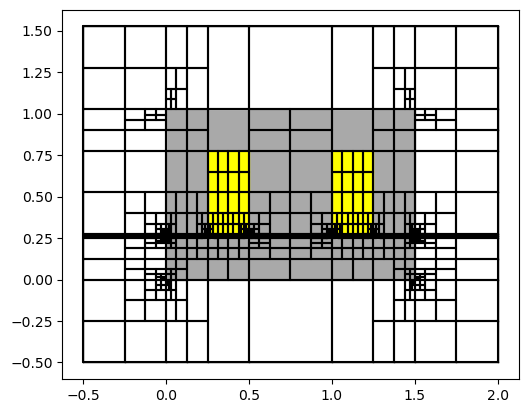

------------------------------------------------------
12
Number of DoFs: 67351
Energy: 0.000884985737217426
Residual contributions took 11.689820766448975 seconds.
Jump contributions took 32.17632269859314 seconds.
Refinement took 18.08165979385376 seconds for 143 patches.
Basis setup took 1.6883835792541504 seconds
Prolongation took 1.1591887474060059 seconds


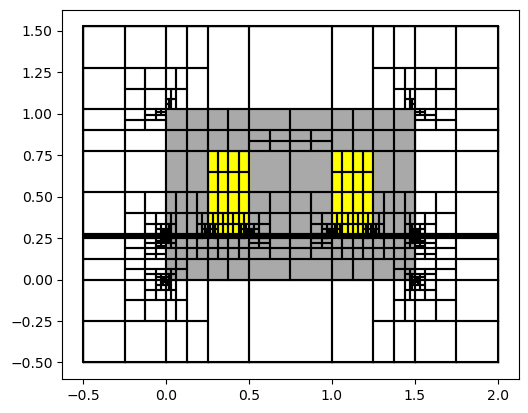

------------------------------------------------------
13
Number of DoFs: 82123
Energy: 0.0008849909882215319
Residual contributions took 14.119616031646729 seconds.
Jump contributions took 39.29213547706604 seconds.
Refinement took 26.785215616226196 seconds for 174 patches.
Basis setup took 2.7489309310913086 seconds
Prolongation took 1.445267915725708 seconds


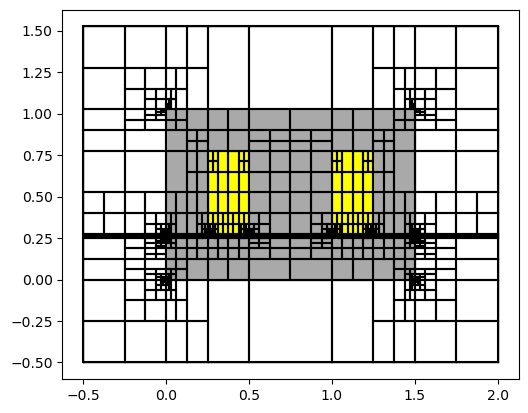

------------------------------------------------------
14
Number of DoFs: 100159
Energy: 0.0008849947549443796
Residual contributions took 17.359517574310303 seconds.
Jump contributions took 48.24702548980713 seconds.
Refinement took 42.79851007461548 seconds for 226 patches.
Basis setup took 3.309128999710083 seconds
Prolongation took 1.9844269752502441 seconds


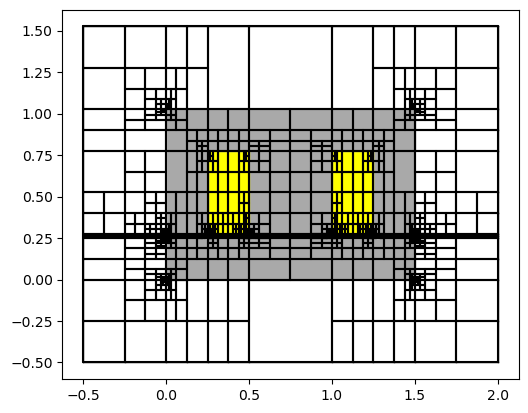

------------------------------------------------------
15
Number of DoFs: 123541
Energy: 0.0008849979413962675
Basis setup took 7.14721417427063 seconds
Prolongation took 7.798363208770752 seconds
------------------------------------------------------
16
Number of DoFs: 349301
Energy: 0.0008849991527426972
Basis setup took 0.015216350555419922 seconds
------------------------------------------------------
0
Number of DoFs: 2793
Energy: 0.0008814047667849434
Residual contributions took 0.26088714599609375 seconds.
Jump contributions took 0.44134044647216797 seconds.
Refinement took 0.037755489349365234 seconds for 7 patches.
Basis setup took 0.028929948806762695 seconds
Prolongation took 0.052073001861572266 seconds


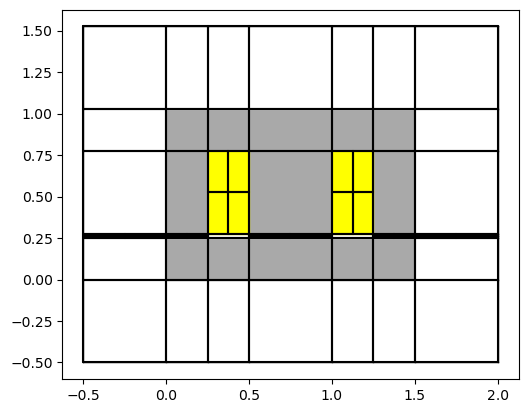

------------------------------------------------------
1
Number of DoFs: 4057
Energy: 0.000882088891291718
Residual contributions took 0.3859126567840576 seconds.
Jump contributions took 0.8886144161224365 seconds.
Refinement took 0.10009932518005371 seconds for 13 patches.
Basis setup took 0.038742780685424805 seconds
Prolongation took 0.09536218643188477 seconds


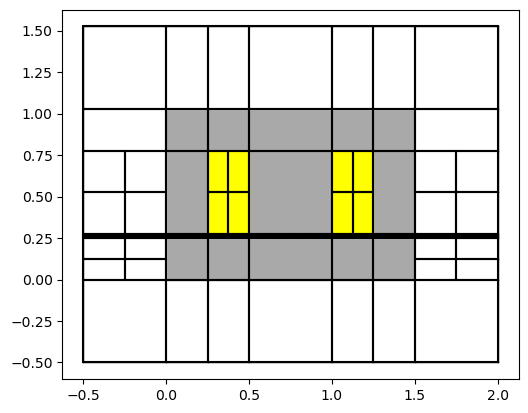

------------------------------------------------------
2
Number of DoFs: 6481
Energy: 0.0008824105829196836
Residual contributions took 0.6543285846710205 seconds.
Jump contributions took 1.4900784492492676 seconds.
Refinement took 0.2058420181274414 seconds for 20 patches.
Basis setup took 0.07421088218688965 seconds
Prolongation took 0.14775562286376953 seconds


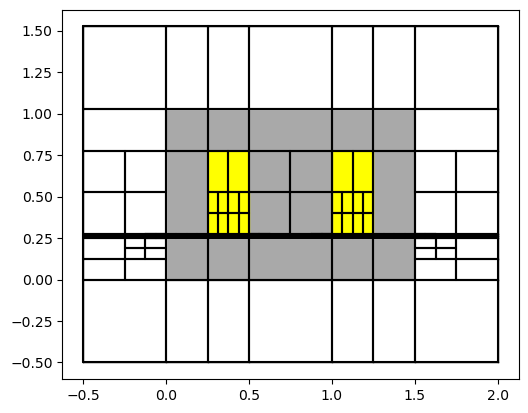

------------------------------------------------------
3
Number of DoFs: 10153
Energy: 0.0008831800318538173
Residual contributions took 1.0580921173095703 seconds.
Jump contributions took 2.543436288833618 seconds.
Refinement took 0.32451486587524414 seconds for 23 patches.
Basis setup took 0.10171031951904297 seconds
Prolongation took 0.167877197265625 seconds


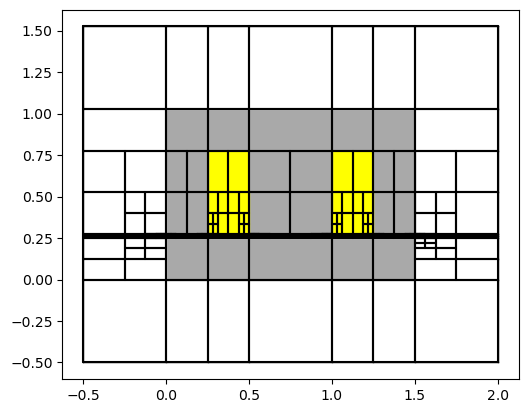

------------------------------------------------------
4
Number of DoFs: 14393
Energy: 0.0008838715429066551
Residual contributions took 1.4448001384735107 seconds.
Jump contributions took 3.662243604660034 seconds.
Refinement took 0.48960232734680176 seconds for 26 patches.
Basis setup took 0.151106595993042 seconds
Prolongation took 0.19353389739990234 seconds


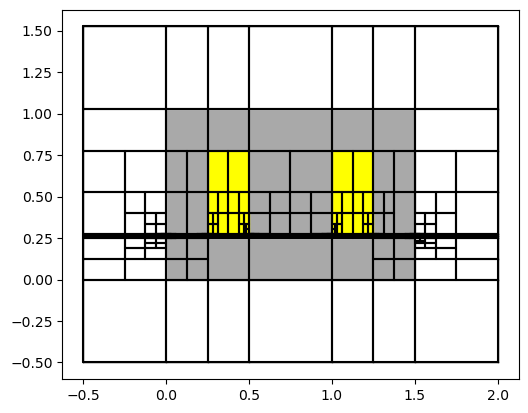

------------------------------------------------------
5
Number of DoFs: 19161
Energy: 0.0008843573892879376
Residual contributions took 1.9346837997436523 seconds.
Jump contributions took 5.0461790561676025 seconds.
Refinement took 0.7413995265960693 seconds for 31 patches.
Basis setup took 0.18175029754638672 seconds
Prolongation took 0.2301805019378662 seconds


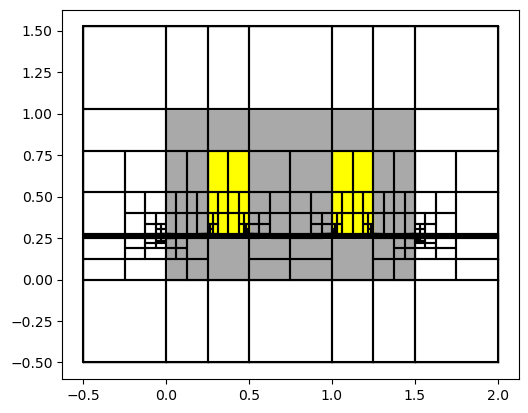

------------------------------------------------------
6
Number of DoFs: 24857
Energy: 0.0008847101578078037
Residual contributions took 2.518177032470703 seconds.
Jump contributions took 6.676700115203857 seconds.
Refinement took 0.9428930282592773 seconds for 32 patches.
Basis setup took 0.2653465270996094 seconds
Prolongation took 0.24453330039978027 seconds


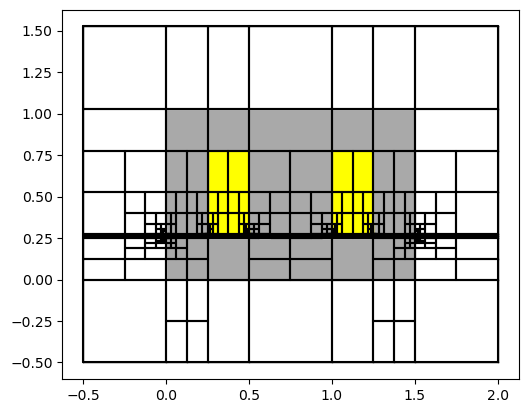

------------------------------------------------------
7
Number of DoFs: 30777
Energy: 0.0008848766510849509
Residual contributions took 3.095123052597046 seconds.
Jump contributions took 8.239270210266113 seconds.
Refinement took 1.3465287685394287 seconds for 38 patches.
Basis setup took 0.36597442626953125 seconds
Prolongation took 0.2910451889038086 seconds


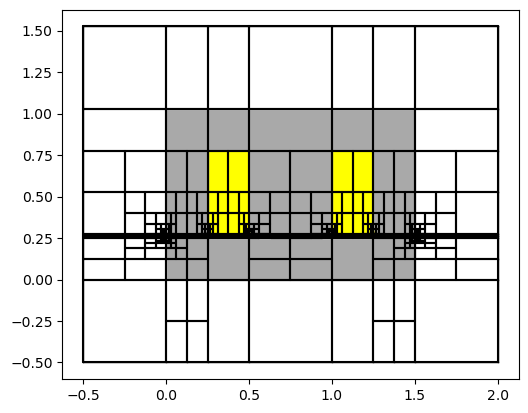

------------------------------------------------------
8
Number of DoFs: 37833
Energy: 0.0008849427700031041
Residual contributions took 3.803781509399414 seconds.
Jump contributions took 10.307260751724243 seconds.
Refinement took 1.8613264560699463 seconds for 43 patches.
Basis setup took 0.45630359649658203 seconds
Prolongation took 0.32884860038757324 seconds


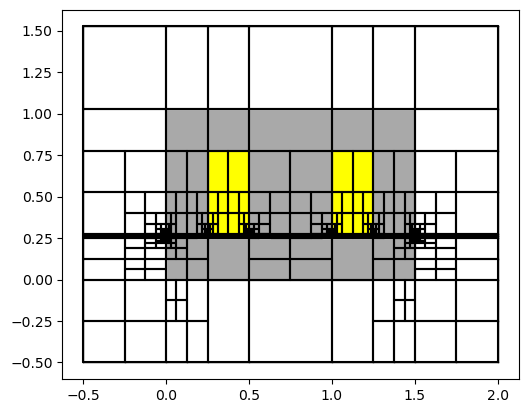

------------------------------------------------------
9
Number of DoFs: 45809
Energy: 0.000884969922724054
Residual contributions took 4.433083534240723 seconds.
Jump contributions took 12.344114065170288 seconds.
Refinement took 3.2258644104003906 seconds for 61 patches.
Basis setup took 0.560732364654541 seconds
Prolongation took 0.4673469066619873 seconds


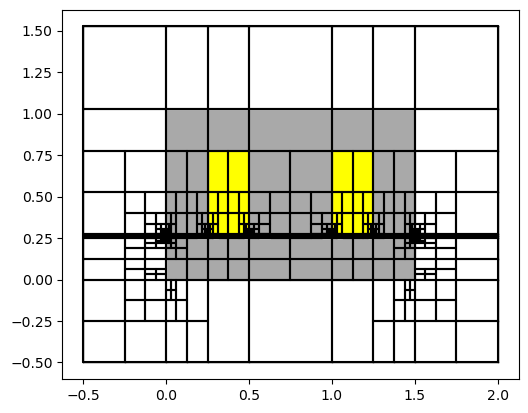

------------------------------------------------------
10
Number of DoFs: 57081
Energy: 0.000884981725047937
Residual contributions took 5.411053895950317 seconds.
Jump contributions took 15.68958568572998 seconds.
Refinement took 4.198549509048462 seconds for 66 patches.
Basis setup took 0.7287309169769287 seconds
Prolongation took 0.5178611278533936 seconds


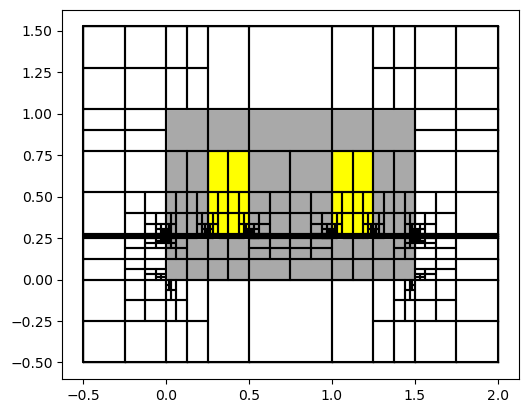

------------------------------------------------------
11
Number of DoFs: 69281
Energy: 0.0008849864634004569
Residual contributions took 6.751443147659302 seconds.
Jump contributions took 18.780548095703125 seconds.
Refinement took 5.434209108352661 seconds for 72 patches.
Basis setup took 1.0777931213378906 seconds
Prolongation took 0.5703201293945312 seconds


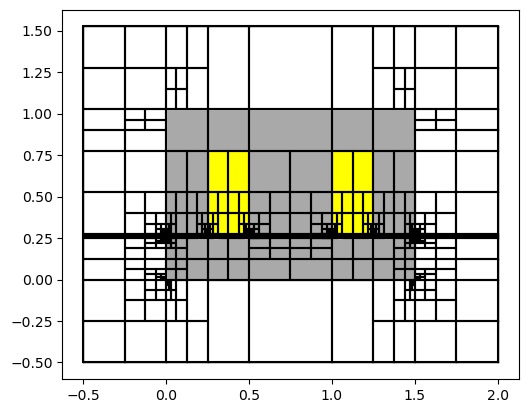

------------------------------------------------------
12
Number of DoFs: 82641
Energy: 0.0008849885372021612
Residual contributions took 7.899600028991699 seconds.
Jump contributions took 22.34041452407837 seconds.
Refinement took 7.749408721923828 seconds for 87 patches.
Basis setup took 1.3122060298919678 seconds
Prolongation took 0.6990761756896973 seconds


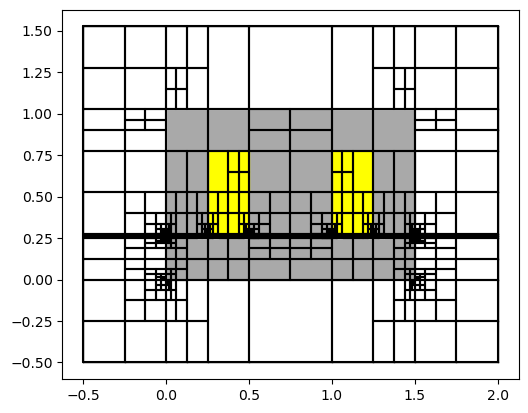

------------------------------------------------------
13
Number of DoFs: 98761
Energy: 0.0008849927313484623
Residual contributions took 9.48583459854126 seconds.
Jump contributions took 26.555285453796387 seconds.
Refinement took 10.13591456413269 seconds for 97 patches.
Basis setup took 1.700437068939209 seconds
Prolongation took 0.7873818874359131 seconds


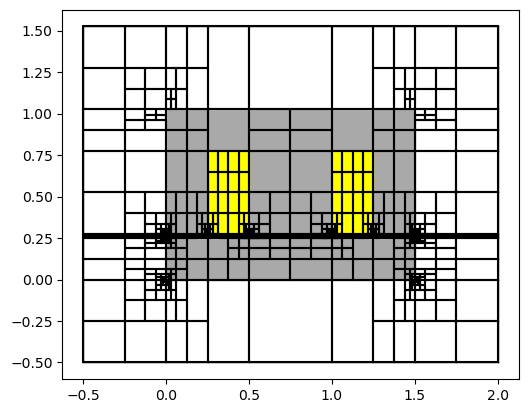

------------------------------------------------------
14
Number of DoFs: 116793
Energy: 0.0008849940557169517
Residual contributions took 11.23748517036438 seconds.
Jump contributions took 31.19213056564331 seconds.
Refinement took 12.99131155014038 seconds for 107 patches.
Basis setup took 2.140209674835205 seconds
Prolongation took 0.8864355087280273 seconds


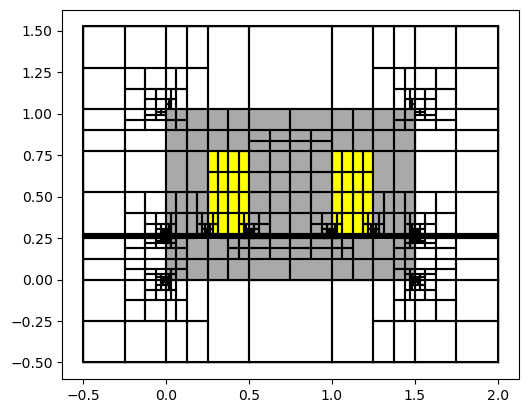

------------------------------------------------------
15
Number of DoFs: 136657
Energy: 0.0008849970966852479
Residual contributions took 13.258049011230469 seconds.
Jump contributions took 37.139404296875 seconds.
Refinement took 16.1468722820282 seconds for 115 patches.
Basis setup took 2.80556058883667 seconds
Prolongation took 0.9717593193054199 seconds


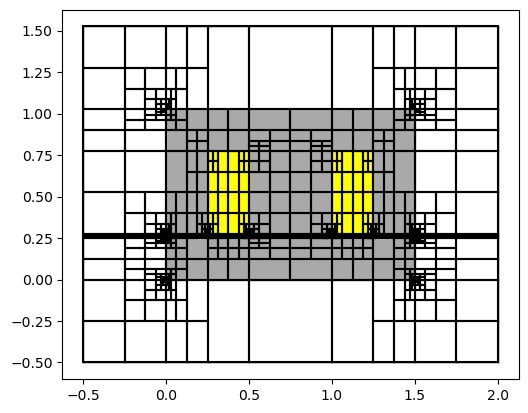

------------------------------------------------------
16
Number of DoFs: 157953
Energy: 0.0008849981295605449
Residual contributions took 15.090791702270508 seconds.
Jump contributions took 42.42460250854492 seconds.
Refinement took 21.728686571121216 seconds for 134 patches.
Basis setup took 3.502169609069824 seconds
Prolongation took 1.1618740558624268 seconds


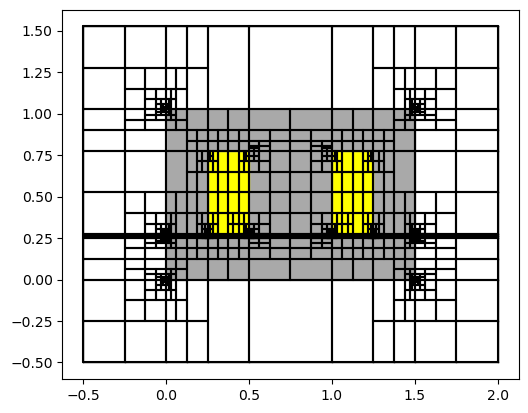

------------------------------------------------------
17
Number of DoFs: 182809
Energy: 0.0008849991274023803
Residual contributions took 17.461957693099976 seconds.
Jump contributions took 49.10230803489685 seconds.
Refinement took 25.185105323791504 seconds for 136 patches.
Basis setup took 4.3781867027282715 seconds
Prolongation took 1.2155711650848389 seconds


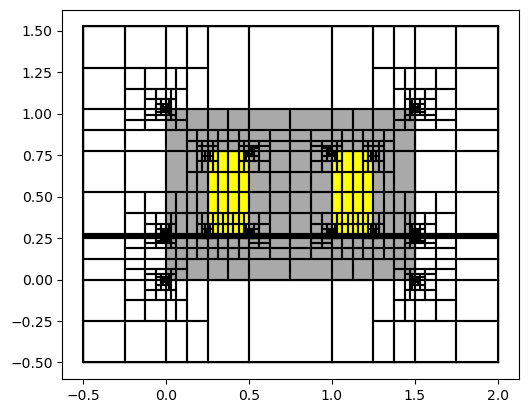

------------------------------------------------------
18
Number of DoFs: 208089
Energy: 0.0008849996744584653
Basis setup took 9.815918445587158 seconds
Prolongation took 7.764177322387695 seconds
------------------------------------------------------
19
Number of DoFs: 556934
Energy: 0.0008849998711408129


In [20]:
for deg, maxiter in zip((2,3,4),(15,17,20)):
    M_a=Inductor(deg,deg+1)
    MP_a = assemble.Multipatch(M_a, automatch=True)
    uh_a=[]
    P_a=[]
    err_ind=[]
    Eh_a=np.zeros(maxiter)
    
    time_mesh_a = np.zeros(maxiter)
    time_solve_a = np.zeros(maxiter)
    time_est_a=np.zeros(maxiter)
    nnz_a=np.zeros(maxiter)
    nnzQ_a=np.zeros(maxiter)

    numdofs_a =np.zeros(maxiter)
    err_est=np.zeros(maxiter)

    for i in range(maxiter):
        print('------------------------------------------------------')
        print(i)
        bcs = MP_a.compute_dirichlet_bcs({0:0.})
        Ah_a = sum([MP_a.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP_a.assemble_volume('j * v * dx', arity=1, domain_id=k, j=j[k], physical=True) for k in j],axis=0)
        Kh_a = MP_a.assemble_volume(vform.stiffness_vf(2))
        Mh_a = MP_a.assemble_volume(vform.mass_vf(2))
        LS = assemble.RestrictedLinearSystem(Ah_a, F, bcs)
        
        nnz_a[i] = LS.A.nnz
        nnzQ_a[i] = 100*LS.A.nnz/np.prod(LS.A.shape)
        
        t=time.time()
        uh_a.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
        time_solve_a[i]=time.time()-t
        Eh_a[i] = 0.0254 * 0.5 * uh_a[-1]@Ah_a@uh_a[-1]
        #h_a[i]=MP_a.integrate('0.5 * nu * inner(grad(uh),grad(uh)) * v * dx', u_=uh_a[-1], nu=nu)*0.0254
        print('Number of DoFs: ' + str(MP_a.numdofs))
        print('Energy: ' + str(Eh_a[i]))
        numdofs_a[i]=MP_a.numdofs

        if i < maxiter-2 :
            t=time.time()
            err_ind.append(adap.PoissonEstimator(MP_a, uh_a[-1], f=j, a=nu, M=MaT))
            time_est_a[i]=time.time()-t
            
            err_est[i] = norm(err_ind[-1])
            marked_patches = adap.doerfler_marking(err_ind[-1], 0.9)
            marked_patches = {p:None for p in marked_patches}
            
            t=time.time()
            P_a.append(MP_a.h_refine(h_ref=marked_patches, return_P=True))
            time_mesh_a[i]=time.time()-t
            
            MP_a.mesh.draw(color={'C1':'yellow', 'C2':'yellow','Fe':'darkgrey','Air':'white'},knots=False)
            plt.show()
        elif i == maxiter-2:
            P_a.append(MP_a.p_refine(p_inc=1, return_P=True))
        else:
            pass

    for k in reversed(range(1,len(P_a))):
        P_a[k-1]=P_a[k]@P_a[k-1]

    L2err_a = np.zeros(maxiter)
    H1err_a = np.zeros(maxiter)
    Aherr_a = np.zeros(maxiter)
    Eherr_a = np.zeros(maxiter)
    for i in range(len(uh_a)-1):
        eh = P_a[i]@uh_a[i]-uh_a[-1]
        L2err_a[i] = eh @ Mh_a @ eh
        H1err_a[i] = eh @ Kh_a @ eh + L2err_a[-1]
        Aherr_a[i] = eh @ Ah_a @ eh
        Eherr_a[i]=abs(Eh_a[-1]-Eh_a[i])

    L2err_a = sqrt(L2err_a)
    H1err_a = sqrt(H1err_a)
    Aherr_a = sqrt(Aherr_a)

    np.savetxt('Ip'+str(deg)+'n'+str(deg+1)+'.txt', np.c_[[numdofs_a, nnz_a, nnzQ_a ,H1err_a,L2err_a,Aherr_a,Eh_a,time_mesh_a,time_est_a,time_solve_a]])

In [12]:
M = Inductor(2,3)
MP = assemble.Multipatch(M, automatch=True)
kvs, geos = MP.mesh.kvs, MP.mesh.geos

Basis setup took 0.013923168182373047 seconds


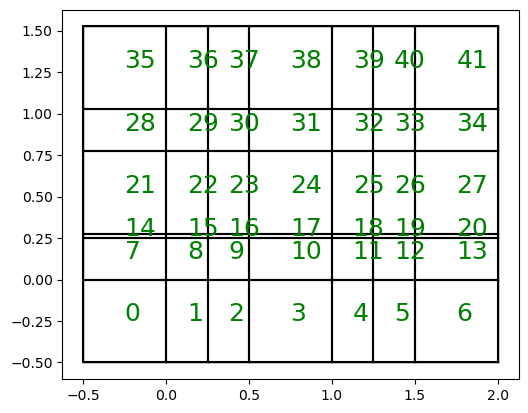

In [13]:
MP.mesh.draw(patch_idx=True)

In [48]:
nu['C1']/nu['Fe']

2500.0000000000005

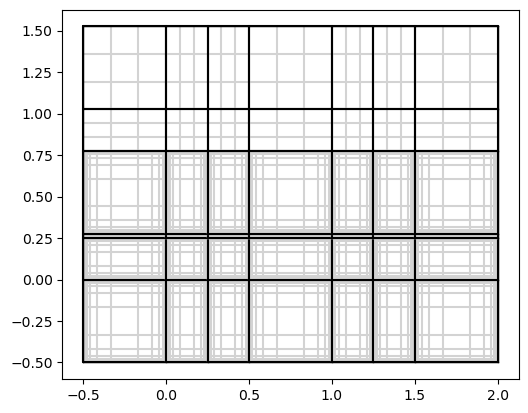

In [41]:
MP_geo.mesh.draw(knots=True)

In [8]:
for i in range(3):
    MP.h_refine();
    adap.PoissonEstimator(MP, uh = np.zeros(MP.numdofs))

Refinement took 0.3822510242462158 seconds for 42 patches.
Basis setup took 0.07076001167297363 seconds
Residual contributions took 1.3554270267486572 seconds.
Refinement took 4.167315483093262 seconds for 168 patches.
Basis setup took 0.2773246765136719 seconds
Residual contributions took 3.829657554626465 seconds.
Refinement took 60.90325403213501 seconds for 672 patches.
Basis setup took 1.7740912437438965 seconds
Residual contributions took 15.303276300430298 seconds.


In [36]:
adap.PoissonEstimator(MP, uh = np.zeros(MP.numdofs))

Residual contributions took 0.9817352294921875 seconds.


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [20]:
len(MP.N_ofs)

43

In [85]:
MP.N_ofs

array([   0,   25,   50,   75,  100,  125,  150,  175,  200,  225,  250,  275,  300,  325,  350,  375,  400,  425,  450,  475,  500,  525,  550,  575,  600,  625,  650,  675,  700,  725,  750,  775,  800,  825,  850,  875,  900,  925,  950,  975, 1000, 1025, 1050])

In [68]:
uh_loc = np.zeros(MP.numloc_dofs)

In [80]:
p=7
uh_loc[MP.N_ofs[p]:MP.N_ofs[p+1]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [92]:
R = np.array([assemble.assemble('(f + div(grad(uh))) * v * dx', kvs=kv0 , geo=geo , f=lambda x,y: 1.,uh=geometry.BSplineFunc(kv, uh_loc[MP.N_ofs[p]:MP.N_ofs[p+1]])).ravel() for p, (kv0, kv, geo) in enumerate(zip(kvs0,kvs,geos))])

In [100]:
h**2 * R.sum(axis=1)

array([1.38889e-02, 4.34028e-03, 4.34028e-03, 1.38889e-02, 4.34028e-03, 4.34028e-03, 1.38889e-02, 4.34028e-03, 8.68056e-04, 8.68056e-04, 4.34028e-03, 8.68056e-04, 8.68056e-04, 4.34028e-03, 3.48090e-04, 4.38368e-05, 4.38368e-05, 3.48090e-04, 4.38368e-05, 4.38368e-05, 3.48090e-04, 1.38889e-02, 4.34028e-03, 4.34028e-03, 1.38889e-02, 4.34028e-03, 4.34028e-03, 1.38889e-02, 4.34028e-03, 8.68056e-04, 8.68056e-04, 4.34028e-03, 8.68056e-04, 8.68056e-04, 4.34028e-03, 1.38889e-02, 4.34028e-03, 4.34028e-03, 1.38889e-02, 4.34028e-03, 4.34028e-03, 1.38889e-02])

In [98]:
R.sum(axis=1)

array([0.25   , 0.125  , 0.125  , 0.25   , 0.125  , 0.125  , 0.25   , 0.125  , 0.0625 , 0.0625 , 0.125  , 0.0625 , 0.0625 , 0.125  , 0.0125 , 0.00625, 0.00625, 0.0125 , 0.00625, 0.00625, 0.0125 , 0.25   , 0.125  , 0.125  , 0.25   , 0.125  , 0.125  , 0.25   , 0.125  , 0.0625 , 0.0625 , 0.125  , 0.0625 , 0.0625 , 0.125  , 0.25   , 0.125  , 0.125  , 0.25   , 0.125  , 0.125  , 0.25   ])

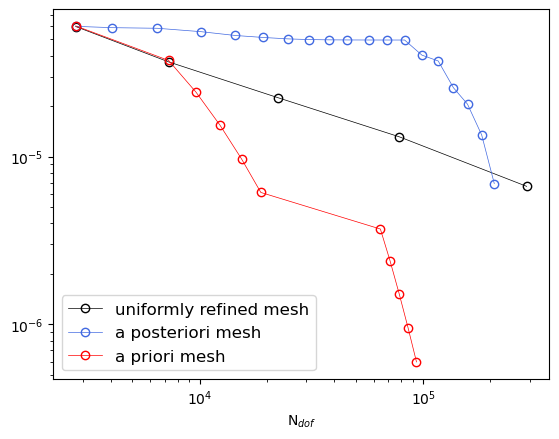

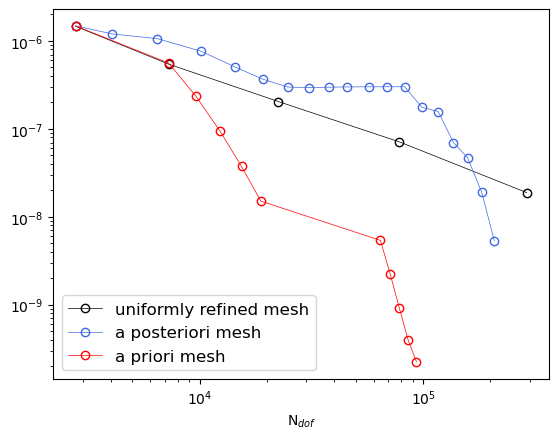

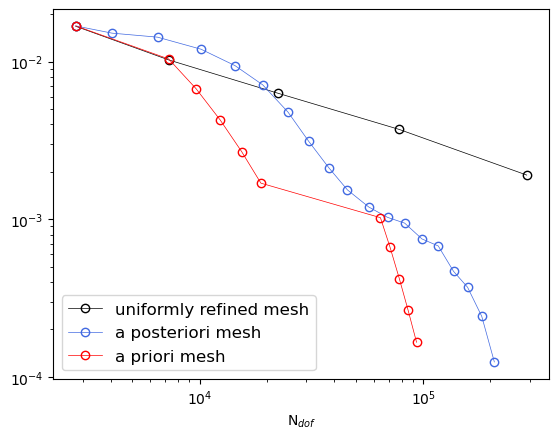

In [34]:
deg=4
[numdofs, nnz, nnzQ, H1err,L2err,Aherr,Eh,time_mesh,time_solve]=np.loadtxt('Ip'+str(deg)+'n'+str(deg+1)+'uni.txt')
[numdofs_a, nnz_a, nnzQ_a ,H1err_a,L2err_a,Aherr_a,Eh_a,time_mesh_a,time_est_a,time_solve_a]=np.loadtxt('Ip'+str(deg)+'n'+str(deg+1)+'.txt')
[numdofs_geo, nnz_geo, nnzQ_geo , H1err_geo, L2err_geo, Aherr_geo, Eh_geo, time_mesh_geo, time_solve_geo]=np.loadtxt('Ip'+str(deg)+'n'+str(deg+1)+'geo.txt')

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], H1err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_geo[:-4], H1err_geo[:-4], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniformly refined mesh','a posteriori mesh','a priori mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

#draw_loglog_slope(fig,ax,(1e5,1.9*1e-2),1,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#draw_loglog_slope(fig,ax,(5*1e4,9*1e-3),1,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

plt.savefig('/home/wolfman/Pictures/Motor/p'+str(deg)+'/Mp'+str(deg)+'n'+str(deg+1)+'H1.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_geo[:-4], L2err_geo[:-4], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniformly refined mesh','a posteriori mesh','a priori mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

#draw_loglog_slope(fig,ax,(1e5,2.5*1e-5),1,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#draw_loglog_slope(fig,ax,(5*1e4,2.5*1e-6),1,int((deg+1)/2) if (deg+1)%2==0 else (deg+1)/2,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

#fig, ax = plt.subplots()
# plt.loglog(numdofs[:-1], Aherr[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
# plt.loglog(numdofs_a[:-1], Aherr_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
# plt.loglog(numdofs_geo[:-1], Aherr_geo[:-1], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.savefig('/home/wolfman/Pictures/Motor/p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2.pdf', bbox_inches='tight')

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], Aherr[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], Aherr_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_geo[:-4], Aherr_geo[:-4], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniformly refined mesh','a posteriori mesh','a priori mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

plt.show()



In [10]:
H1err_a

array([0.00014, 0.00013, 0.00011, 0.00011, 0.0001 , 0.0001 , 0.0001 , 0.0001 , 0.0001 , 0.     ])

In [11]:
L2err_a

array([8.16256e-06, 6.96800e-06, 3.68782e-06, 2.46796e-06, 1.95109e-06, 1.85318e-06, 1.85839e-06, 1.86715e-06, 1.87316e-06, 0.00000e+00])

In [20]:
Eerr

array([6.99408e-05, 3.97206e-05, 1.91405e-05, 7.74537e-06, 2.38368e-06, 1.22320e-07, 0.00000e+00])

In [16]:
Eerr

array([6.99408e-05, 3.97206e-05, 1.91405e-05, 7.74537e-06, 2.38368e-06, 1.22320e-07, 0.00000e+00])

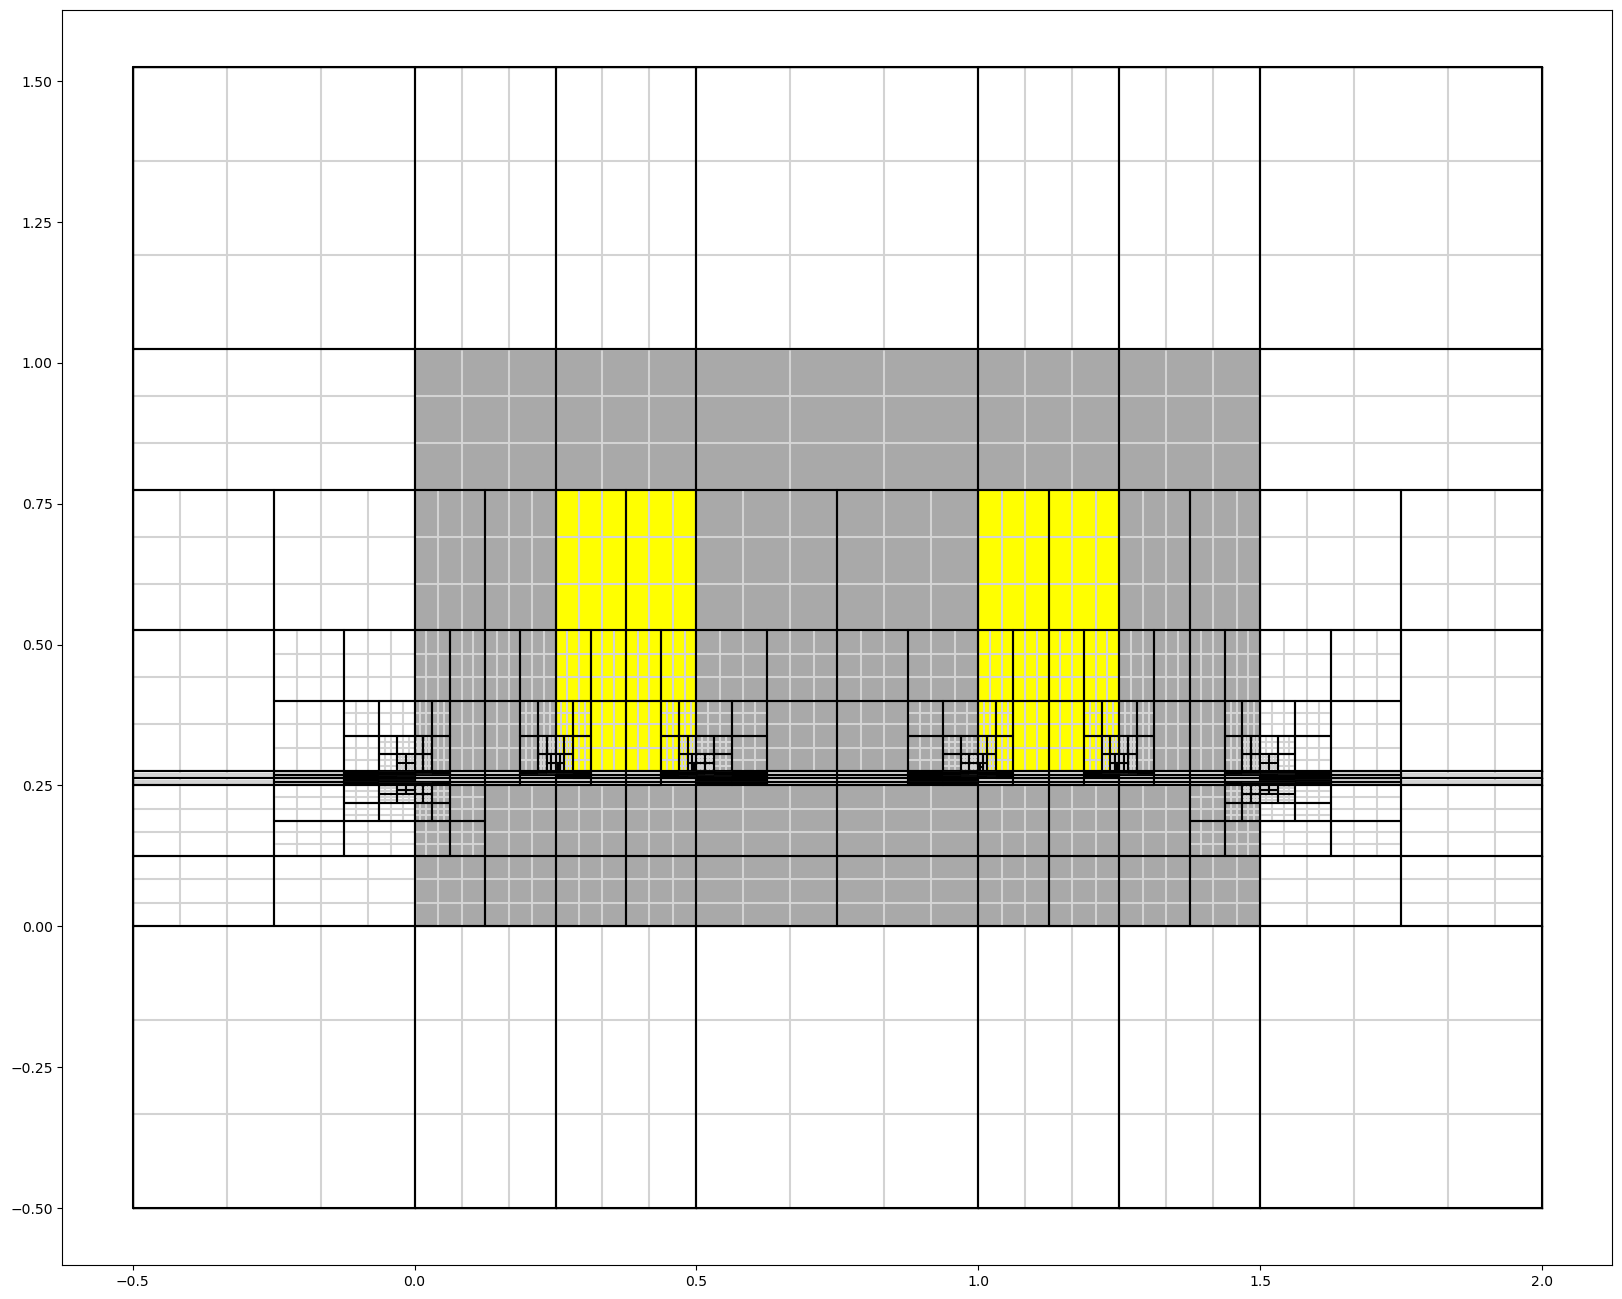

In [34]:
MP_a.mesh.draw(knots=True, color={'C1':'yellow', 'C2':'yellow','Fe':'darkgrey','Air':'white'}, figsize=(20,20))

In [ ]:
M.draw(knots=True, patch_idx=False, figsize=(10,10), color={'Air':'white', 'Fe':'darkgray', 'C1':'yellow', 'C2':'yellow'})

In [12]:
MP_a.integrate

{'Air': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}}

In [24]:
bd1=geometry.line_segment((1,0),(2,0))
bd3=geometry.line_segment((0,1),(0,2))
bd4=geometry.line_segment((0,1),(1,0))

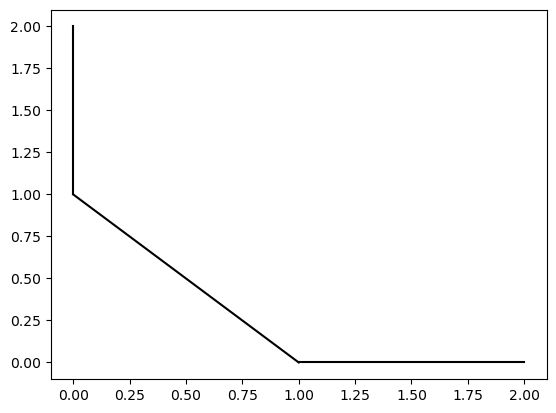

In [26]:
vis.plot_geo(bd3)
vis.plot_geo(bd3)
vis.plot_geo(bd4)

In [36]:
bd2=geometry.BSplineFunc(bspline.KnotVector(np.array([0,0,0,1,1,1]),2),coeffs=np.array([[2.,0.],
                                                                                        [2.,2.],
                                                                                        [0.,2.]]))

In [53]:
bd1.kvs

(KnotVector(array([0., 0., 1., 1.]), 1),)

In [59]:
geo=geometry.quarter_annulus()

In [61]:
geo.coeffs_weights()

(array([[[1., 0.],
         [2., 0.]],
 
        [[1., 1.],
         [2., 2.]],
 
        [[0., 1.],
         [0., 2.]]]),
 array([[1.     , 1.     ],
        [0.70711, 0.70711],
        [1.     , 1.     ]]))

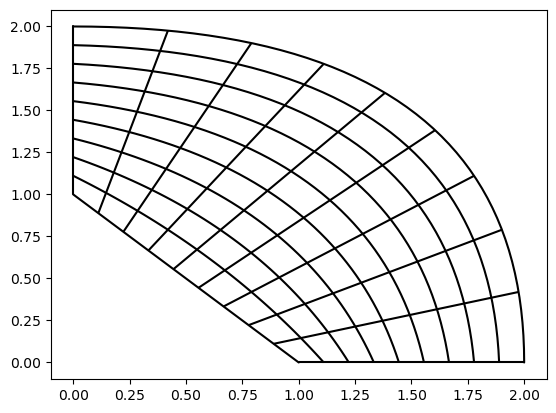

In [3]:
vis.plot_geo(geometry.bspline_annuseg())